In [1]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import mdtraj
import urllib.request
import yaml
import pprint
#from OrderParameter import *

# SAMULI: Also this should be maybe moved to the external code that will be imported
# Download link
def download_link(doi, file):
    if "zenodo" in doi.lower():
        zenodo_entry_number = doi.split(".")[2]
        return 'https://zenodo.org/record/' + zenodo_entry_number + '/files/' + file
    else:
        print ("DOI provided: {0}".format(doi))
        print ("Repository not validated. Please upload the data for example to zenodo.org")
        return ""

Number of entries:  16
Total size of trajectories:  71.46199576184154 Gb


Text(0, 0.5, 'Distribution')

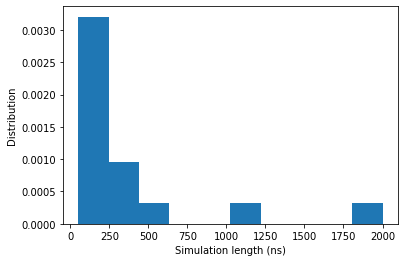

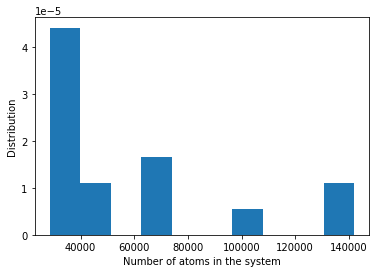

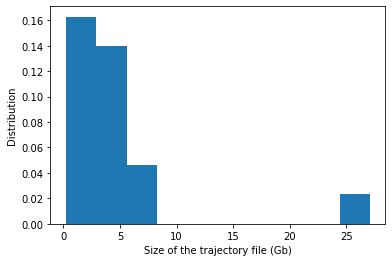

In [18]:
# Demonstration of reading the databank
# Currently lists some information on the simulations in the databank

# List of lipids that will be analyzed
lipids = {'POPC', 'POPG','POPE','POPS'} 
angles = []

# This walks through the files in the databank
# Dictionaries saved as README.yaml are read into 'readme' dictionary

count = 0
simL = []
Natoms = []
trjSIZE = []

for subdir, dirs, files in os.walk(r'../../Data/Simulations/'):
    for filename in files:
        filepath = subdir + os.sep + filename
        if filepath.endswith("README.yaml"):
            READMEfilepath = subdir + '/README.yaml'
            with open(READMEfilepath) as yaml_file:
                readme = yaml.load(yaml_file, Loader=yaml.FullLoader)
                #print(subdir)
                doi = readme.get('DOI')
                trj = readme.get('TRJ')
                tpr = readme.get('TPR')
                trj_name = subdir + '/' + readme.get('TRJ')[0][0]
                tpr_name = subdir + '/' + readme.get('TPR')[0][0]
                gro_name = subdir + '/conf.gro'
                trj_url = download_link(doi, trj[0][0])
                tpr_url = download_link(doi, tpr[0][0])
                EQtime=float(readme.get('TIMELEFTOUT'))*1000
            
                #print(readme)
                count = count + 1
                simL.append(readme.get('TRJLENGTH')*0.001)
                if readme.get('NUMBER_OF_ATOMS'):
                    Natoms.append(float(readme.get('NUMBER_OF_ATOMS')))
                trjSIZE.append(readme.get('TRAJECTORY_SIZE')/(1024*1024*1024))
                                
print("Number of entries: ",count)
print("Total size of trajectories: ",str(np.sum(trjSIZE)) + ' Gb')
distSIMl = plt.hist(simL, density=True)
plt.xlabel('Simulation length (ns)')
plt.ylabel('Distribution')
plt.figure()
distNatoms = plt.hist(Natoms, density=True)
plt.xlabel('Number of atoms in the system')
plt.ylabel('Distribution')
plt.figure()
disttrjSIZE = plt.hist(trjSIZE, density=True)
plt.xlabel('Size of the trajectory file (Gb)')
plt.ylabel('Distribution')
#print(simL)